In [1]:
# Preamble

from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
import sys
sys.path.append('../../../astro_codes/')

In [3]:
def make_axes():
    fig, axarr = plt.subplots(2,1,figsize=(10,10),sharex=True)
    plt.subplots_adjust(hspace=0,wspace=0)
    return fig, axarr

In [4]:
samples = Table.read('../matched_fits/samples.fits')
gas_samples = Table.read('../matched_fits/gas_samples.fits')
flux_masks = Table.read('../matched_fits/bad_flux_mask.fits')

In [5]:
in_ml_spirals = ((samples['in_mass_limit']) & 
                 (samples['axial_ok']) & 
                 (samples['in_spiral']))

In [6]:
import scipy.stats.distributions as dist
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

def get_fractional_errors(k,n,c=0.683):
    
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    
    return p_lower,p_upper


def get_tables_with_errors(table,normalise='fraction',error=True,column_totals=None):
    
    '''
    --- Method for calculating the 'counting' errors for individual columns
    of a table---
    
    Inputs:
    -------
    table: set of values to input.
    
    normalise: if 'fraction', all values add to 1. If 'percent' all values add to 100.
    Else, raw values will be used.
    
    error: if True, then the tables with low/high fractions will be the errors;
    if False, then they will correspond to fractions. (eg. 0.75+/-0.05 will return 
    0.7 and 0.8 if False, or 0.05 and 0.05 if True).
    
    column_totals: if None, then the column total is the sum of that column. 
    
    Outputs:
    --------
    fracs: table of fractions/ numbers (with same shape as table. If normalise isn't 
    'percent' or 'fraction',fracs will be the same as Table)
    
    fracs_low, fracs_high: exactly the same format as fracs/table, but with corresponding
    error values.
    '''
    
    fracs_low = Table()
    fracs = Table()
    fracs_high = Table()
    
    for i,c in enumerate(table.colnames):
        column = table[c]
        if column_totals == None:
            column_total = np.sum(column)
        else:
            column_total = column_totals[i]
        f = column/column_total
        f_low, f_high = get_fractional_errors(column,column_total)
        if error:
            f_low = f-f_low
            f_high = f_high-f
        if normalise == 'percent':
            f, f_low, f_high = [f*100,f_low*100,f_high*100]
        elif normalise == 'fraction':
            f, f_low, f_high = [f,f_low,f_high]
        else:
            f, f_low, f_high = [f*column_total,f_low*column_total,f_high*column_total]
        
        fracs_low[c] = f_low
        fracs[c] = f
        fracs_high[c] = f_high
    
    return fracs, fracs_low, fracs_high


def comparison_line_plot(table,labels,colors,markersize=6,markers=['o'],linewidths=[2],
                         normalise='percent',column_totals=None,right_space=2,ylabel='$\%$',
                         legend=False,joinwidth=0):


    column_labels = table.colnames
    N_columns = len(column_labels) # 'columns' = number of bar 'groups'
    
    column_centres = [j+0.5 for j in range(N_columns)]
    N_class = len(table)
    
    fracs, fracs_low, fracs_high = get_tables_with_errors(table,normalise,error=True,
                                                          column_totals=column_totals)
    
    for n in range(N_class):
        
        linewidth = linewidths[n]
        color = colors[n]
        marker = markers[n]
        label = labels[n]
        class_f = [fracs[c][n] for c in column_labels]
        class_low_error = [fracs_low[c][n] for c in column_labels]
        class_high_error = [fracs_high[c][n] for c in column_labels]

        _ = plt.errorbar(column_centres,class_f, yerr=[class_low_error,class_high_error]
                         ,markersize=markersize,linewidth=joinwidth,marker=marker,
                         ecolor=color,capsize=4,elinewidth=linewidth,capthick=linewidth,
                         label=label,color=color)
    if legend is True:
        plt.legend(fontsize=15)
    plt.xlim(column_centres[0]-1,column_centres[-1]+right_space)
    plt.xticks(column_centres,column_labels)
    plt.ylabel(ylabel)
    
    return fracs, fracs_low, fracs_high

In [7]:
detections = Table()
column_labels = ['1','2','3','4','5+']
column_totals = []

has_fuv = flux_masks['fuv']
has_mir = flux_masks['w4']
has_both = (has_fuv) & (has_mir)

for m in range(5):
    column_label = column_labels[m]
    in_m = (in_ml_spirals) & (samples['m'] == m)
    column = [np.sum(mask[in_m]) for mask in [has_fuv,has_mir,has_both]]
    detections[column_label] = column
    column_totals.append(np.sum(in_m))
#############################################
a70_targeted = gas_samples['in_a70_region']

gas_detections = Table()
gas_column_totals = []

has_gas = gas_samples['has_a70']

for m in range(5):
    column_label = column_labels[m]
    in_m = (in_ml_spirals) & (samples['m'] == m) & (a70_targeted)
    column = [np.sum(has_gas[in_m])]
    gas_detections[column_label] = column
    gas_column_totals.append(np.sum(in_m))

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


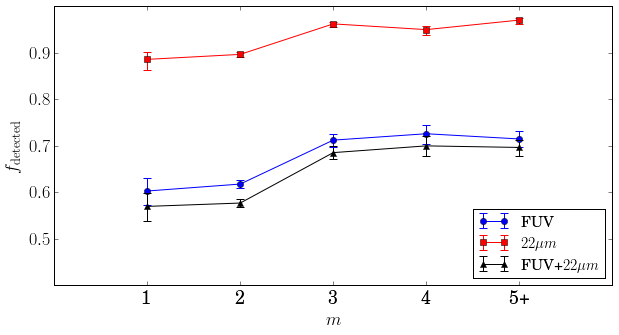

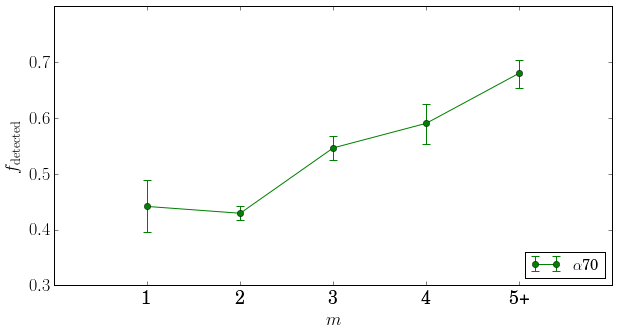

In [8]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

_ = comparison_line_plot(detections,labels=['FUV','$22 \mu m$','FUV+$22 \mu m$'],colors='brk'
                         ,markersize=6,markers=['o','s','^'],linewidths=[1,1,1],
                         normalise='fraction',column_totals=column_totals,right_space=1,ylabel='$f_\mathrm{detected}$',
                         joinwidth=1)

ax.legend(loc='lower right',fontsize=15)
ax.set_ylim(0.4,1)
ax.set_xlabel('$m$')
plt.savefig('../output_figures/sfr_m_completeness.pdf')

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

_ = comparison_line_plot(gas_detections,labels=[r'$\alpha$70'],colors='g'
                         ,markersize=6,markers=['o'],linewidths=[1],
                         normalise='fraction',column_totals=gas_column_totals,right_space=1,ylabel='$f_\mathrm{detected}$',
                         joinwidth=1)

ax.legend(loc='lower right',fontsize=15)
ax.set_ylim(0.3,0.8)
ax.set_xlabel('$m$')
plt.savefig('../output_figures/gas_m_completeness.pdf')

#plt.savefig('../output_figures/sfr_m_completeness.pdf')

In [9]:
# now create the barred and unbarred samples for comparison?

two_arms = samples['m'] == 1
many_arms = samples['m'] > 1
barred = samples['barred']
unbarred = samples['barred'] == False

b_values = np.array([(two_arms) & (unbarred),
                      (two_arms) & (barred),
                      (many_arms) & (unbarred),
                      (many_arms) & (barred)]).T

b_ok = np.sum(b_values,axis=1) > 0

b_samples = np.argmax(b_values,axis=1)
b_samples[b_ok == False] = -999

In [10]:
detections = Table()
column_labels = ['2 (unbarred)', '2 (barred)', r'$>$2 (unbarred)', r'$>$2 (barred)']
column_totals = []

for b in range(4):
    column_label = column_labels[b]
    in_b = (in_ml_spirals) & (b_samples == b)
    column = [np.sum(mask[in_b]) for mask in [has_fuv,has_mir,has_both]]
    detections[column_label] = column
    column_totals.append(np.sum(in_b))

#############################################

gas_detections = Table()
gas_column_totals = []

has_gas = gas_samples['has_a70']

for b in range(4):
    column_label = column_labels[b]
    in_b = (in_ml_spirals) & (b_samples == b) & (a70_targeted)
    column = [np.sum(has_gas[in_b])]
    gas_detections[column_label] = column
    gas_column_totals.append(np.sum(in_b))

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


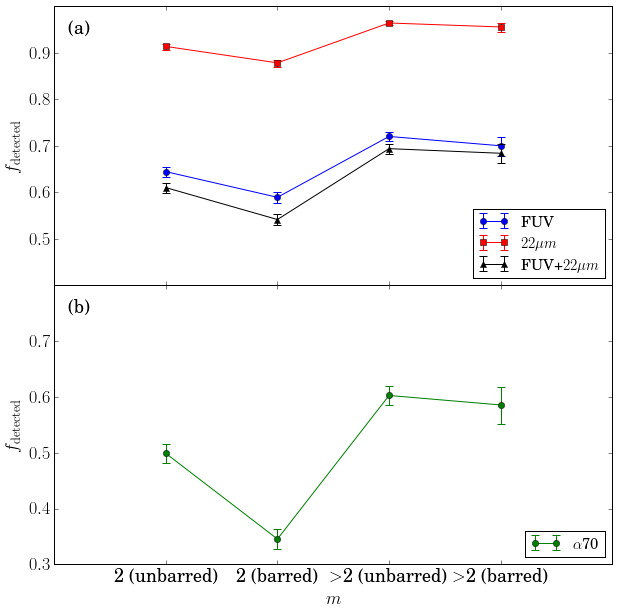

In [13]:
fig, axarr = make_axes()

plt.sca(axarr[0])
_ = comparison_line_plot(detections,labels=['FUV','$22 \mu m$','FUV+$22 \mu m$'],colors='brk'
                         ,markersize=6,markers=['o','s','^'],linewidths=[1,1,1],
                         normalise='fraction',column_totals=column_totals,right_space=1,ylabel='$f_\mathrm{detected}$',
                         joinwidth=1)
axarr[0].text(0.025,0.95,'(a)',
              ha='left',va='top',transform=axarr[0].transAxes)

plt.sca(axarr[1])
_ = comparison_line_plot(gas_detections,labels=[r'$\alpha$70'],colors='g'
                         ,markersize=6,markers=['o'],linewidths=[1],
                         normalise='fraction',column_totals=gas_column_totals,right_space=1,ylabel='$f_\mathrm{detected}$',
                         joinwidth=1)
axarr[1].text(0.025,0.95,'(b)',
              ha='left',va='top',transform=axarr[1].transAxes)

axarr[0].legend(loc='lower right',fontsize=15)
axarr[1].legend(loc='lower right',fontsize=15)

axarr[0].set_ylim(0.4,1)
axarr[1].set_ylim(0.3,0.8)
axarr[1].set_xlabel('$m$')

plt.savefig('../output_figures/b_completeness.pdf')